In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas_datareader as pdr
from statsmodels import api as sm

In [2]:
def bootstrap_optimal(pnls:pd.DataFrame,frac:float=0.1,n_samples:int=100):
  pnls = pnls.dropna()
  sample_size = round(pnls.shape[0] * frac)
  
  bootstrap = pnls.sample(n=n_samples*sample_size, replace=True, axis=0).reset_index(drop=True)
  
  mu = bootstrap.groupby(bootstrap.index//sample_size).mean()
  sig = bootstrap.groupby(bootstrap.index//sample_size).std()
  sr = mu / sig
  
  optimal = sr.apply(lambda r: np.argmax(r),axis=1)
  rank = optimal.value_counts().sort_values(ascending=False)
  rank.index = rank.index.map(lambda x: bootstrap.columns[x])
  return rank

In [3]:
symbols = ['AUDUSD=X','GBPUSD=X','EURUSD=X','CADUSD=X']
data = yf.download(symbols[0])

[*********************100%***********************]  1 of 1 completed


In [10]:
from feature_generation import gen_all

feat = gen_all(data)

c:\ProgramData\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
c:\ProgramData\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [12]:
from feature_generation import check_stationarity
check_stationarity(feat)

ImportError: cannot import name 'check_stationarity' from 'feature_generation' (e:\Document\GitHub\Trading-Modules\feature_generation.py)

In [4]:
from ta.momentum import roc
from ta.momentum import rsi
from ta.momentum import stoch
from ta.momentum import williams_r

from ta.volatility import average_true_range
from ta.volatility import bollinger_pband
from ta.volatility import donchian_channel_pband
from ta.volatility import ulcer_index
def volatility(close,window): return np.log(close).diff().rolling(window).std().ffill()

from ta.trend import adx
from ta.trend import cci
from ta.trend import macd_diff

In [53]:
def ind_corr(data,windows):
  data = np.log(data)
  o,h,l,c = data.Open,data.High,data.Low,data.Close
  
  ind = pd.DataFrame()
  for w in windows:
    ind[w] = williams_r(h,l,c,w)
  sns.heatmap(np.around(ind.corr(),2),annot=True)
  return ind

c:\ProgramData\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


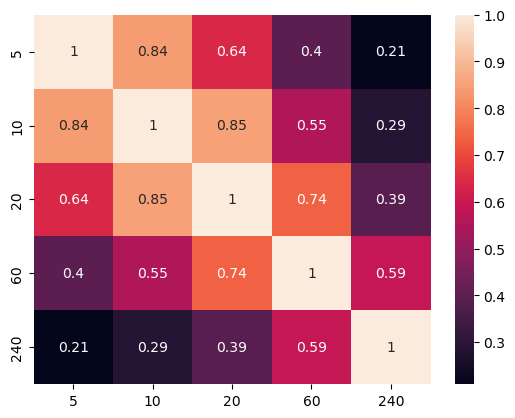

In [54]:
windows = [5,10,20,60,240]
ind = ind_corr(data,windows)

In [6]:
from sklearn.decomposition import PCA

def pca_transform(variations:pd.DataFrame,n_components:int):
  variations = variations.dropna()
  pca = PCA(n_components=n_components)
  pca.fit(variations)
  explained = pd.Series(pca.explained_variance_ratio_)
  pca_variations = pd.DataFrame(pca.transform(variations),index=variations.index)
  print(explained)
  return pca_variations[0]

In [41]:
def pca_transform(variations:pd.DataFrame,n_components:int):
  variations = variations.dropna()
  pca = PCA(n_components=n_components)
  pca.fit(variations)
  #explained = pd.Series(pca.explained_variance_ratio_)
  #print(explained)
  pca_variations = pd.DataFrame(pca.transform(variations),index=variations.index)
  return pca_variations.iloc[:,0]

In [45]:
def pca_transform(variations:pd.DataFrame,n_components:int):
  variations = variations.dropna()
  pca = PCA(n_components=n_components)
  #explained = pd.Series(pca.explained_variance_ratio_)
  #print(explained)
  #pca_variations = pd.DataFrame(pca.transform(variations),index=variations.index)
  return pca.fit_transform(variations)[-1,0]

def rolling_pca(variations:pd.DataFrame,n_components:int,min_window:int):
  variations = variations.dropna()
  pca_feature = pd.Series()
  for i in range(min_window,variations.shape[0]):
    #start = variations.index[i-min_window]
    end = variations.index[i]
    data = variations.loc[:end]
    pca_feature.loc[end] = pca_transform(data,n_components)
  return pca_feature

In [44]:
pca_transform(ind,5)#.iloc[-1]

Date
2006-06-09   -11.326915
2006-06-12   -50.680642
2006-06-13   -68.125674
2006-06-14   -66.868777
2006-06-15   -31.419362
                ...    
2024-02-13   -25.026146
2024-02-14   -69.621452
2024-02-15   -29.823669
2024-02-16   -10.112084
2024-02-19    -2.852487
Name: 0, Length: 4605, dtype: float64

<Axes: xlabel='Date'>

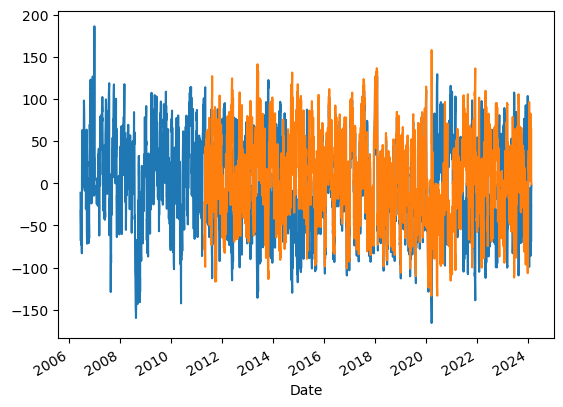

In [35]:
pca_transform(ind,5).plot()
pca_ind.plot()

In [46]:
pca_ind = rolling_pca(ind,5,252)

C:\Users\benka\AppData\Local\Temp\ipykernel_8972\3804539919.py:11: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pca_feature = pd.Series()


<Axes: >

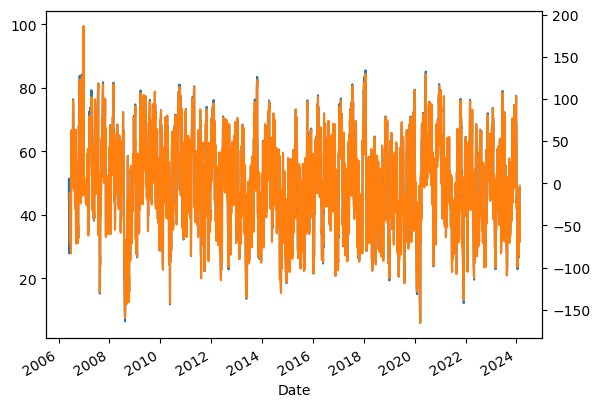

In [32]:
ind[10].plot()
pca_transform(ind,5).plot(secondary_y=True)

<Axes: xlabel='10'>

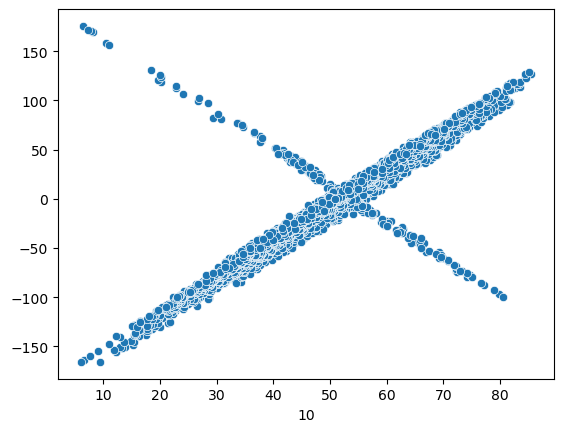

In [47]:
sns.scatterplot(
x = ind[10],
y = pca_ind
)

In [65]:
from ta.momentum import roc
from ta.momentum import rsi
from ta.momentum import stoch
from ta.momentum import williams_r

from ta.volatility import average_true_range
from ta.volatility import bollinger_pband
from ta.volatility import donchian_channel_pband
from ta.volatility import ulcer_index
def volatility(close,window): return close.diff().rolling(window).std().ffill()

from ta.trend import adx
from ta.trend import cci
from ta.trend import macd_diff

def gen_TA(bars:pd.DataFrame):
  logbars = np.log(bars)
  o,h,l,c = logbars.Open,logbars.High,logbars.Low,logbars.Close
  ta = pd.DataFrame()
  
  for w in [5,10,20,60,120,240]:
    # momentum
    ind = 'roc' + '_' + str(w)
    ta[ind] = roc(c,w)
    
    ind = 'rsi' + '_' + str(w)
    ta[ind] = rsi(c,w)
    
    ind = 'stoch' + '_' + str(w)
    ta[ind] = stoch(h,l,c,w)
    
    ind = 'willr' + '_' + str(w)
    ta[ind] = williams_r(h,l,c,w)
    
    # volatility
    ind = 'atr' + '_' + str(w)
    ta[ind] = average_true_range(h,l,c,w)
    
    ind = 'bollp' + '_' + str(w)
    ta[ind] = bollinger_pband(c,w)
    
    ind = 'doncp' + '_' + str(w)
    ta[ind] = stoch(h,l,c,w)
    
    ind = 'ui' + '_' + str(w)
    ta[ind] = williams_r(h,l,c,w)
    
    ind = 'vol' + '_' + str(w)
    ta[ind] = volatility(c,w)
    
    # trend
    ind = 'adx' + '_' + str(w)
    ta[ind] = adx(h,l,c,w)
    
    ind = 'cci' + '_' + str(w)
    ta[ind] = cci(h,l,c,w)
    
    ind = 'macd' + '_' + str(w)
    ta[ind] = macd_diff(c,w,w//2,w//3)
  
  return ta.dropna(axis=1,how='all').dropna()

In [66]:
gen_TA(data)

c:\ProgramData\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


,roc_5,rsi_5,stoch_5,willr_5,atr_5,bollp_5,doncp_5,ui_5,vol_5,adx_5,...,stoch_240,willr_240,atr_240,bollp_240,doncp_240,ui_240,vol_240,adx_240,cci_240,macd_240
Date,,,,,,,,,,,,,,,,,,,,,
2007-08-03,-4.272951,40.504821,78.083277,-21.916723,0.012113,0.644625,78.083277,-21.916723,0.006040,58.353364,...,7.976100,-92.023900,0.018323,0.631511,7.976100,-92.023900,0.161449,0.000000,90.090845,0.005337
2007-08-06,0.338474,41.860155,80.876211,-19.123789,0.011026,0.700660,80.876211,-19.123789,0.004837,56.506346,...,8.004333,-91.995667,0.018275,0.631609,8.004333,-91.995667,0.161449,0.000000,88.204169,0.005237
2007-08-07,-2.238283,34.503606,64.158813,-35.841187,0.010549,0.218515,64.158813,-35.841187,0.003265,56.063327,...,7.792939,-92.207061,0.018234,0.622704,7.792939,-92.207061,0.161449,0.000000,84.834686,0.005105
2007-08-08,-6.240317,57.428164,96.267141,-3.732859,0.010450,0.937795,96.267141,-3.732859,0.005119,47.231324,...,8.311128,-91.688872,0.018200,0.641192,8.311128,-91.688872,0.161450,0.000000,92.477310,0.005048
2007-08-09,5.994241,34.297089,7.823884,-92.176116,0.012272,0.112936,7.823884,-92.176116,0.008666,45.626289,...,7.512337,-92.487663,0.018206,0.610092,7.512337,-92.487663,0.161451,0.000000,83.004224,0.004871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-13,-1.722485,48.493349,86.077451,-13.922549,0.009254,0.671752,86.077451,-13.922549,0.004487,39.286615,...,32.694079,-67.305921,0.012032,0.394006,32.694079,-67.305921,0.006170,3.283163,-46.508778,0.003606
2024-02-14,2.756769,26.445497,6.961007,-93.038993,0.009924,0.039238,6.961007,-93.038993,0.005953,44.499078,...,23.236053,-76.763947,0.012035,0.263557,23.236053,-76.763947,0.006208,3.279170,-68.913204,0.003398
2024-02-15,0.829511,45.212147,57.097311,-42.902689,0.010272,0.481546,57.097311,-42.902689,0.007324,38.456175,...,28.936499,-71.063501,0.012033,0.344239,28.936499,-71.063501,0.006188,3.277314,-47.359898,0.003256
